In [1]:
import networkx as nx
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [3]:
plt.rcParams["figure.figsize"] = (20,3)

In [4]:
from shared.schema import DatasetSchema, GraphSchema
from shared.graph import DataGraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [5]:
DATASET = DatasetSchema.load_schema('misc-football')
schema = GraphSchema.from_dataset(DATASET)
G = DataGraph.from_schema(schema)

In [6]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 1

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: False
Has edge timestamp: False


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [7]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

In [8]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

No node timestamp data available


In [9]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

No edge timestamp data available


# Global Statistics

In [10]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 115
Number of Edges: 1226
Density: 0.0935163996948894


In [11]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [12]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 21.321739130434782
Median Degree: 22.0


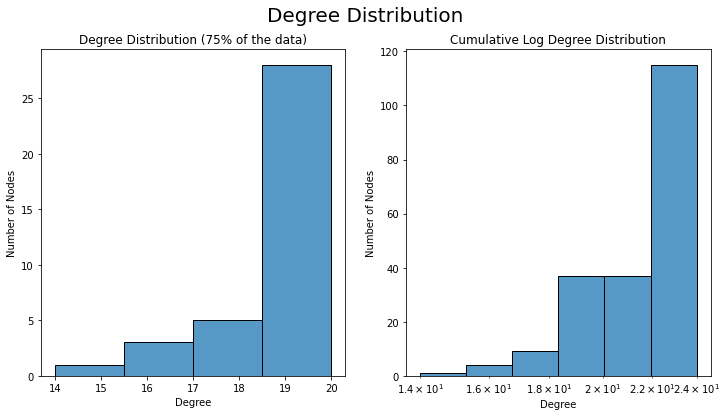

In [13]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [14]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,24,1
1,24,8
2,24,68
3,24,16
4,24,105
5,24,2
6,24,54
7,24,89
8,24,7
9,24,6


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [15]:
# Use the largest connected component
G_cc = G.components("weak").giant()
G_cc.to_undirected()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [16]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.408
Diameter: 4


In [17]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

,degree_centrality,betweenness_centrality,eigenvector_centrality,page_rank,transitivity
count,115.000000,115.000000,115.000000,115.000000,115.000000
mean,0.093516,0.013119,0.091767,0.008696,0.403216
std,0.007784,0.026965,0.016642,0.000576,0.104221
min,0.061404,0.000000,0.048312,0.006269,0.111111
25%,0.087719,0.000000,0.080094,0.008320,0.362374
50%,0.096491,0.002880,0.089921,0.008848,0.400000
75%,0.096491,0.012330,0.104755,0.008990,0.472727
max,0.105263,0.161341,0.127683,0.009677,0.666667


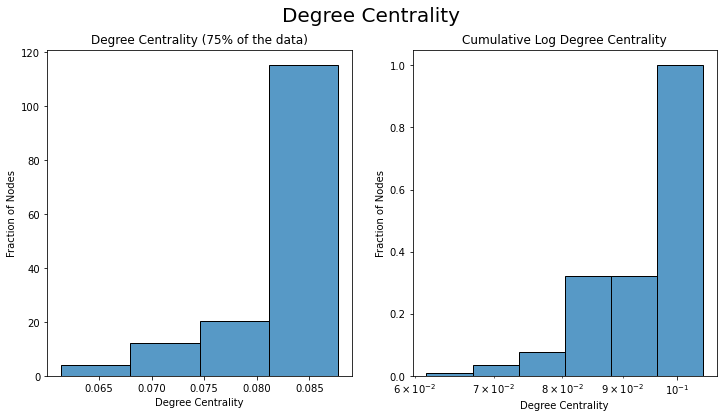

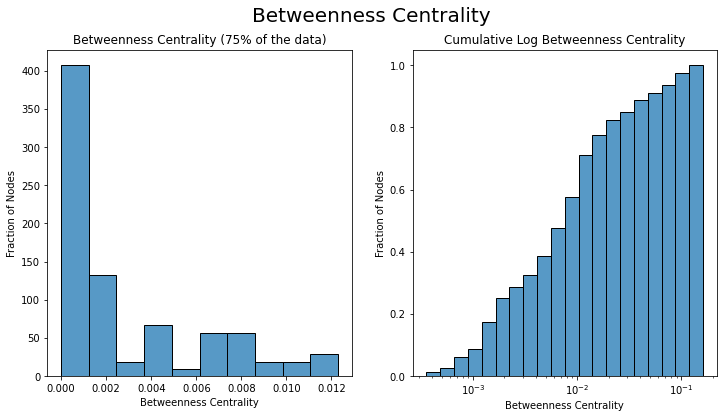

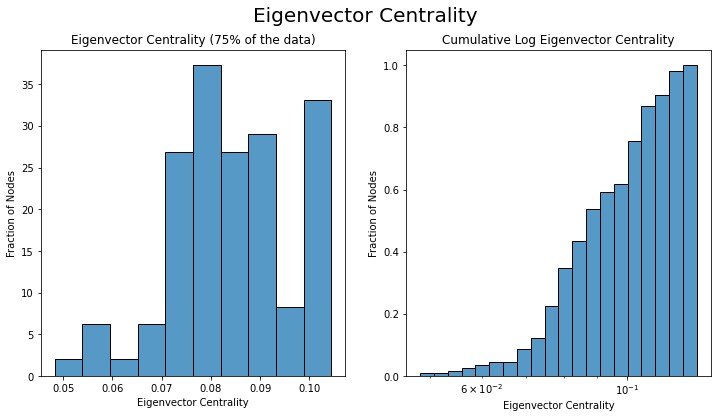

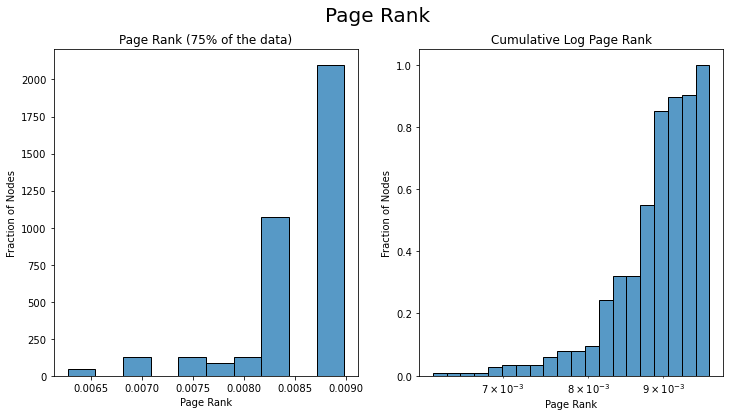

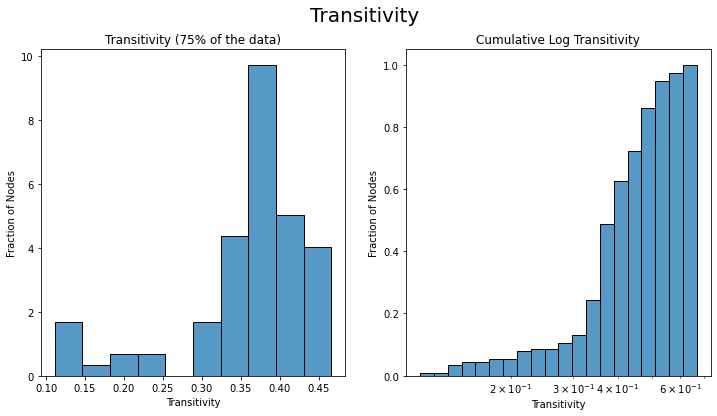

In [18]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [19]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.105263,1,0.161341,83,0.127683,68,0.009677,6,0.666667,106
1,0.105263,8,0.135377,103,0.122577,54,0.009641,2,0.644444,34
2,0.105263,68,0.101416,16,0.121289,89,0.009617,4,0.622222,104
3,0.105263,16,0.098320,65,0.120724,8,0.009588,1,0.600000,95
4,0.105263,105,0.094191,100,0.119902,74,0.009548,7,0.577778,109
5,0.105263,2,0.086649,14,0.119568,47,0.009541,105,0.563636,84
6,0.105263,54,0.065745,7,0.117695,115,0.009510,16,0.545455,115
7,0.105263,89,0.056886,33,0.117246,50,0.009509,3,0.545455,50
8,0.105263,7,0.047554,48,0.116471,84,0.009495,89,0.533333,42
9,0.105263,6,0.038908,93,0.116303,16,0.009491,8,0.527273,38


## Connected Components Statistics

In [20]:
print(f'Number of Connected Components: {len(G.components("weak"))}')
largest_cc = G.components("weak").giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 1
Size of the largest component: 115


Text(0.5, 1.0, 'Connected Components')

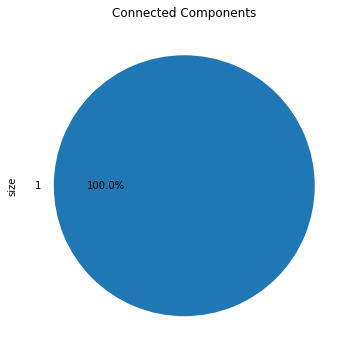

In [21]:
df_tmp = pd.Series(list(map(len, G.components("weak"))), name='size', index=range(1,len(G.components("weak"))+1))
ax = df_tmp.sort_values(ascending=False).head(30).plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [22]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 1


,type,count,degree_avg,degree_median
Team,Team,115,21.321739,22.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

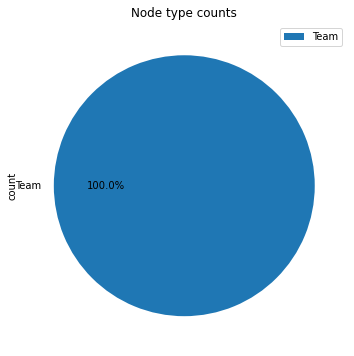

In [23]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

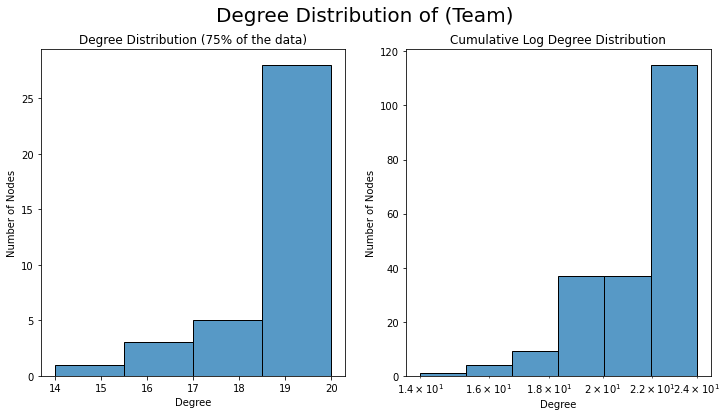

In [24]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [25]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (Team)


,value,label
0,24,1
1,24,8
2,24,68
3,24,16
4,24,105
5,24,2
6,24,54
7,24,89
8,24,7
9,24,6


### Edge Type Statistics

In [26]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 1


,type,count
PLAYS,PLAYS,1226


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

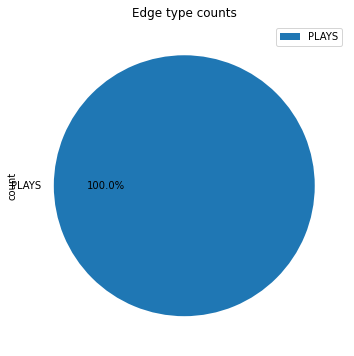

In [27]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [28]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [29]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for Team


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.105263,1,0.161341,83,0.127683,68,0.009677,6,0.666667,106
1,0.105263,8,0.135377,103,0.122577,54,0.009641,2,0.644444,34
2,0.105263,68,0.101416,16,0.121289,89,0.009617,4,0.622222,104
3,0.105263,16,0.098320,65,0.120724,8,0.009588,1,0.600000,95
4,0.105263,105,0.094191,100,0.119902,74,0.009548,7,0.577778,109
5,0.105263,2,0.086649,14,0.119568,47,0.009541,105,0.563636,84
6,0.105263,54,0.065745,7,0.117695,115,0.009510,16,0.545455,115
7,0.105263,89,0.056886,33,0.117246,50,0.009509,3,0.545455,50
8,0.105263,7,0.047554,48,0.116471,84,0.009495,89,0.533333,42
9,0.105263,6,0.038908,93,0.116303,16,0.009491,8,0.527273,38


# Clustering

## No Clustering Modularity

In [30]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 0.0


### Louvain

In [31]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.6044072289092501
Number of communities: 9


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

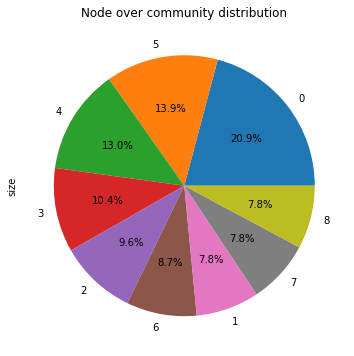

In [32]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [33]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.105263,1,0.022052,94,0.120724,8,0.009588,1,0.577778,109
1,0.105263,8,0.021997,10,0.113703,105,0.009541,105,0.533333,42
2,0.105263,105,0.014789,22,0.111198,112,0.009491,8,0.527273,79
3,0.096491,5,0.012376,69,0.110323,23,0.009007,70,0.511111,94
4,0.096491,79,0.009801,8,0.110187,69,0.008887,5,0.509091,23
5,0.096491,78,0.008015,112,0.110067,78,0.008883,79,0.472727,78
6,0.096491,70,0.008015,23,0.109969,22,0.008873,52,0.472727,69
7,0.096491,69,0.006388,78,0.107811,9,0.008861,24,0.472727,52
8,0.096491,52,0.002304,9,0.106532,10,0.008848,17,0.472727,112
9,0.096491,112,0.002029,105,0.106503,1,0.008844,9,0.472727,10


No node timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.105263,2,0.024308,104,0.096385,2,0.009641,2,0.666667,106
1,0.096491,26,0.022287,46,0.093379,26,0.008981,38,0.644444,34
2,0.096491,38,0.015208,90,0.091472,90,0.008962,110,0.622222,104
3,0.096491,46,0.001984,38,0.090543,46,0.008919,90,0.527273,38
4,0.096491,90,0.000000,2,0.087270,110,0.008918,46,0.527273,46
5,0.096491,110,0.000000,26,0.086034,38,0.008909,26,0.527273,110
6,0.087719,34,0.000000,34,0.083368,34,0.008232,104,0.509091,26
7,0.087719,104,0.000000,106,0.081921,106,0.008225,106,0.509091,90
8,0.087719,106,0.000000,110,0.081745,104,0.008215,34,0.439394,2


No node timestamp data available
Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.105263,3,0.101416,16,0.116303,16,0.009548,7,0.418182,40
1,0.105263,7,0.098320,65,0.116262,3,0.009510,16,0.400000,101
2,0.105263,16,0.086649,14,0.112856,7,0.009509,3,0.400000,107
3,0.096491,14,0.065745,7,0.110053,48,0.008888,61,0.381818,14
4,0.096491,33,0.056886,33,0.109209,33,0.008842,65,0.381818,33
5,0.096491,40,0.047554,48,0.106501,101,0.008838,40,0.381818,48
6,0.096491,48,0.036271,3,0.106450,65,0.008828,14,0.381818,61
7,0.096491,61,0.035749,40,0.105995,14,0.008827,107,0.381818,65
8,0.096491,65,0.027460,107,0.105028,107,0.008825,101,0.378788,3
9,0.096491,101,0.013609,61,0.104385,40,0.008800,33,0.348485,16


No node timestamp data available
Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.105263,4,0.135377,103,0.106250,4,0.009677,6,0.444444,11
1,0.105263,6,0.012686,4,0.104367,75,0.009617,4,0.422222,53
2,0.096491,41,0.008655,75,0.103321,82,0.008947,99,0.422222,103
3,0.096491,73,0.008440,99,0.102965,41,0.008882,73,0.422222,108
4,0.096491,75,0.008432,108,0.102272,6,0.008881,85,0.381818,73
5,0.096491,82,0.007249,53,0.102143,85,0.008870,41,0.381818,75
6,0.096491,85,0.006353,82,0.100993,73,0.008861,82,0.381818,85
7,0.096491,99,0.005599,11,0.096211,99,0.008853,75,0.363636,6
8,0.087719,11,0.004464,41,0.092862,53,0.008212,11,0.363636,82
9,0.087719,53,0.004382,73,0.091595,108,0.008204,103,0.363636,99


No node timestamp data available
Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.096491,19,0.094191,100,0.082628,62,0.009144,44,0.488889,55
1,0.096491,32,0.013941,39,0.082554,32,0.009132,19,0.444444,72
2,0.096491,35,0.011580,62,0.080489,39,0.009101,35,0.422222,100
3,0.096491,39,0.010988,13,0.076862,72,0.009069,39,0.400000,19
4,0.096491,44,0.006993,19,0.076817,35,0.009018,32,0.381818,32
5,0.096491,62,0.004666,15,0.076631,15,0.009014,62,0.381818,35
6,0.087719,13,0.004464,35,0.076032,55,0.008392,27,0.377778,15
7,0.087719,15,0.004174,32,0.075395,100,0.008382,13,0.361111,86
8,0.087719,27,0.003111,86,0.075121,19,0.008323,15,0.333333,13
9,0.087719,55,0.000000,27,0.074571,44,0.008317,100,0.333333,27


No node timestamp data available
Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.096491,18,0.033109,64,0.083820,88,0.009069,77,0.444444,96
1,0.096491,21,0.017756,59,0.082526,63,0.009035,28,0.444444,114
2,0.096491,28,0.012283,57,0.081789,18,0.009030,21,0.422222,57
3,0.096491,63,0.008570,60,0.081418,66,0.009021,66,0.422222,97
4,0.096491,66,0.003986,18,0.081215,21,0.009018,18,0.418182,77
5,0.096491,71,0.003776,63,0.080553,71,0.009016,71,0.363636,21
6,0.096491,77,0.001854,21,0.079513,28,0.008995,88,0.363636,28
7,0.096491,88,0.001792,71,0.079146,59,0.008985,63,0.363636,63
8,0.087719,57,0.001497,66,0.077289,77,0.008371,59,0.363636,66
9,0.087719,59,0.001349,28,0.075553,57,0.008369,114,0.363636,71


No node timestamp data available


### Label Propagation

In [34]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.5834541965941842
Number of communities: 12


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

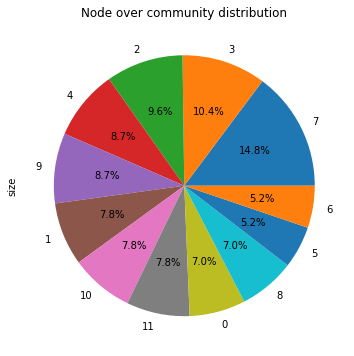

In [35]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [36]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.105263,1,0.022052,94,0.113703,105,0.009588,1,0.533333,42
1,0.105263,105,0.021997,10,0.106532,10,0.009541,105,0.511111,94
2,0.096491,5,0.002029,105,0.106503,1,0.008887,5,0.472727,10
3,0.096491,10,0.001152,24,0.104482,24,0.008861,24,0.454545,24
4,0.096491,17,0.000687,5,0.103791,17,0.008848,17,0.418182,5
5,0.096491,24,0.000576,1,0.101190,5,0.008836,10,0.418182,17
6,0.087719,42,0.000000,17,0.099137,42,0.008157,94,0.363636,105
7,0.087719,94,0.000000,42,0.094104,94,0.008127,42,0.348485,1


No timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.105263,2,0.024308,104,0.096385,2,0.009641,2,0.666667,106
1,0.096491,26,0.022287,46,0.093379,26,0.008981,38,0.644444,34
2,0.096491,38,0.015208,90,0.091472,90,0.008962,110,0.622222,104
3,0.096491,46,0.001984,38,0.090543,46,0.008919,90,0.527273,38
4,0.096491,90,0.000000,2,0.087270,110,0.008918,46,0.527273,46
5,0.096491,110,0.000000,26,0.086034,38,0.008909,26,0.527273,110
6,0.087719,34,0.000000,34,0.083368,34,0.008232,104,0.509091,26
7,0.087719,104,0.000000,106,0.081921,106,0.008225,106,0.509091,90
8,0.087719,106,0.000000,110,0.081745,104,0.008215,34,0.439394,2


No timestamp data available
Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.105263,3,0.101416,16,0.116303,16,0.009548,7,0.418182,40
1,0.105263,7,0.098320,65,0.116262,3,0.009510,16,0.400000,101
2,0.105263,16,0.086649,14,0.112856,7,0.009509,3,0.400000,107
3,0.096491,14,0.065745,7,0.110053,48,0.008888,61,0.381818,14
4,0.096491,33,0.056886,33,0.109209,33,0.008842,65,0.381818,33
5,0.096491,40,0.047554,48,0.106501,101,0.008838,40,0.381818,48
6,0.096491,48,0.036271,3,0.106450,65,0.008828,14,0.381818,61
7,0.096491,61,0.035749,40,0.105995,14,0.008827,107,0.381818,65
8,0.096491,65,0.027460,107,0.105028,107,0.008825,101,0.378788,3
9,0.096491,101,0.013609,61,0.104385,40,0.008800,33,0.348485,16


No timestamp data available
Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.105263,4,0.135377,103,0.106250,4,0.009677,6,0.444444,11
1,0.105263,6,0.012686,4,0.104367,75,0.009617,4,0.422222,53
2,0.096491,41,0.008655,75,0.103321,82,0.008947,99,0.422222,103
3,0.096491,73,0.008440,99,0.102965,41,0.008882,73,0.422222,108
4,0.096491,75,0.008432,108,0.102272,6,0.008881,85,0.381818,73
5,0.096491,82,0.007249,53,0.102143,85,0.008870,41,0.381818,75
6,0.096491,85,0.006353,82,0.100993,73,0.008861,82,0.381818,85
7,0.096491,99,0.005599,11,0.096211,99,0.008853,75,0.363636,6
8,0.087719,11,0.004464,41,0.092862,53,0.008212,11,0.363636,82
9,0.087719,53,0.004382,73,0.091595,108,0.008204,103,0.363636,99


No timestamp data available
Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.105263,8,0.014789,22,0.120724,8,0.009491,8,0.577778,109
1,0.096491,9,0.012376,69,0.111198,112,0.008883,79,0.527273,79
2,0.096491,22,0.009801,8,0.110323,23,0.008873,52,0.509091,23
3,0.096491,23,0.008015,23,0.110187,69,0.008844,9,0.472727,9
4,0.096491,52,0.008015,112,0.110067,78,0.008824,69,0.472727,52
5,0.096491,69,0.006388,78,0.109969,22,0.008816,78,0.472727,69
6,0.096491,78,0.002304,9,0.107811,9,0.008813,22,0.472727,78
7,0.096491,79,0.000000,52,0.104305,79,0.008813,23,0.472727,112
8,0.096491,112,0.000000,79,0.104248,52,0.008809,112,0.454545,22
9,0.087719,109,0.000000,109,0.100990,109,0.008123,109,0.393939,8


No timestamp data available
Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.096491,70,0.001894,12,0.089273,70,0.009007,70,0.388889,51
1,0.087719,12,0.001263,51,0.080319,25,0.008345,12,0.333333,29
2,0.087719,25,0.001226,29,0.079868,12,0.008311,25,0.333333,91
3,0.078947,29,0.001037,25,0.075597,91,0.007636,29,0.311111,12
4,0.078947,51,0.000000,70,0.074342,51,0.007600,51,0.236364,70
5,0.078947,91,0.000000,91,0.070110,29,0.007587,91,0.222222,25


No timestamp data available
